## Analyzing data with OpenML
This is a simple example where we:
- Download an EEG dataset from OpenML
- Visualize it
- Build and analyze machine learning models locally
- Train, evaluate and upload a classifier to OpenML
- Compare it to all other models built on that same dataset by other people

In [181]:
%matplotlib inline
import openml as oml
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from sklearn import neighbors, model_selection

### Download dataset, extract data, plot
The dataset (#1471 on OpenML) contains EEG data (top) labeled with whether your eyes are open or closed at the time of measurement (bottom).

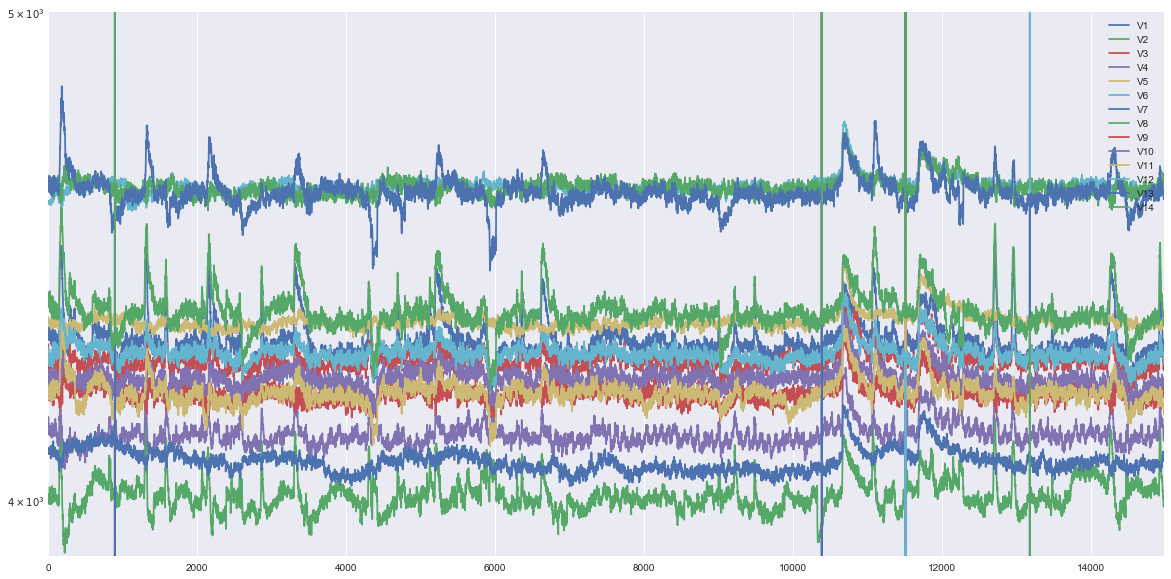

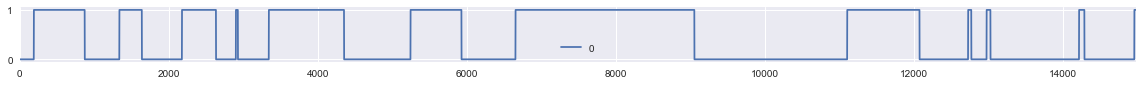

In [193]:
dataset = oml.datasets.get_dataset(1471)
X, y, attribute_names = dataset.get_data(target=dataset.default_target_attribute, return_attribute_names=True)
eeg = pd.DataFrame(X, columns=attribute_names)
eeg.plot(logy=True,ylim=(3900,5000),figsize=(20,10))
pd.DataFrame(y).plot(figsize=(20,1));

### Train simple machine learning model and predict
Using scikit-learn

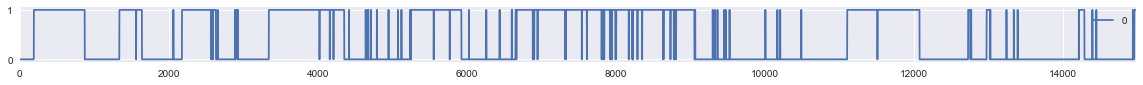

In [152]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
pd.DataFrame(clf.predict(X)).plot(figsize=(20,1))

### or evaluate

In [112]:
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
results = model_selection.cross_val_score(clf, X, y, cv=kfold)
print("Accuracy: %.3f%% (+- %.3f)" % (results.mean(), results.std()))

Accuracy: 0.976% (+- 0.002)


### Use OpenML tasks to easily build, evaluate, and upload models
A completely self-contained experiments in 5 lines of code:
- Download the task (a wrapper around the data also including evaluation details, e.g. train/test splits)
- Create any scikit-learn classifier (or pipeline)
- Convert the pipeline to an OpenML 'flow' and run it on the task
- Publish (upload) if you want

In [167]:
task = oml.tasks.get_task(14951)
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
flow = oml.flows.sklearn_to_flow(clf)
run = oml.runs.run_flow_on_task(task, flow)
myrun = run.publish()
print("Uploaded to http://www.openml.org/r/" + str(myrun.run_id))

Uploaded to http://www.openml.org/r/7932096


### Download everyone else's results on the same dataset
Check whether other people built better models on the same task by downloading their evaluations (computed on the OpenML server) and comparing directly against them.

In [ ]:
myruns = oml.runs.list_runs(task=[14951],size=10000)
scores = []
for id, _ in myruns.items():
    run = oml.runs.get_run(id)
    if str.startswith(run.flow_name, 'sklearn'):
        scores.append({"flow":run.flow_name, "score":run.evaluations['predictive_accuracy']})

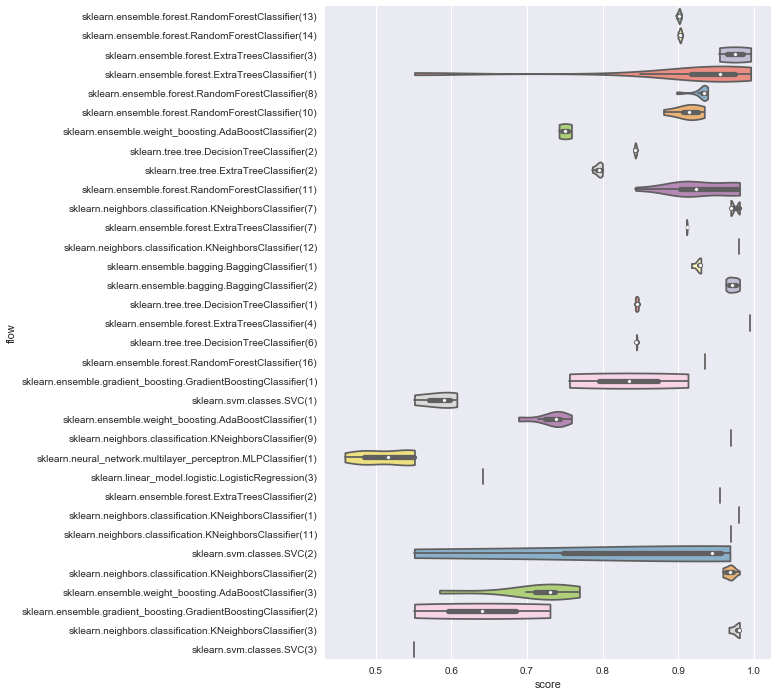

In [190]:
fig, ax = pyplot.subplots(figsize=(8, 12))
sns.violinplot(x="score", y="flow", data=pd.DataFrame(scores), scale="width", palette="Set3", cut=0);